In [1]:
import torch
import time

from nn_handler.utils import parallel_on_all_devices, _resolve_device

In [2]:
device = _resolve_device("cuda")

In [3]:
from nn_handler import __version__

print(__version__)

0.3.27+ddp


In [4]:
print(f"Available GPUs: {torch.cuda.device_count()}")

Available GPUs: 2


In [5]:
data = torch.randn(2, 1)
print(f"{data.device = }")
print(f"{data = }")

data.device = device(type='cpu')
data = tensor([[-1.4343],
        [-0.6782]])


# Split data on devices

In [6]:
@parallel_on_all_devices
def data_split(data):
    device = data.device  # or torch.cuda.current_device()

    print(f"{device} -> {data.shape = }: {data}")

    return data + 1

In [7]:
result = data_split(data)
print(f"{result = }")

cuda:1 -> data.shape = torch.Size([1, 1]): tensor([[-0.6782]], device='cuda:1')
cuda:0 -> data.shape = torch.Size([1, 1]): tensor([[-1.4343]], device='cuda:0')
result = tensor([[-0.4343],
        [ 0.3218]], device='cuda:0')


# Instantiating other tensors on gpus

In [8]:
@parallel_on_all_devices
def instantiating_tensors(data):
    new_tensor = torch.randn(2, 1)
    new_tensor_current_gpu = new_tensor.cuda()  # or new_tensor.to(data.device)

    print(f"{new_tensor.device = }      vs      {new_tensor_current_gpu.device = }")

In [9]:
instantiating_tensors(data)

new_tensor.device = device(type='cpu')      vs      new_tensor_current_gpu.device = device(type='cuda', index=0)
new_tensor.device = device(type='cpu')      vs      new_tensor_current_gpu.device = device(type='cuda', index=1)


# Quirks

### Single device execution

In [10]:
@parallel_on_all_devices
def single_device():
    # Providing no arguments to the function forces the backend to not split
    # any tensor and therefore running on the primary device.
    print(f"{torch.cuda.current_device() = }")

single_device()

torch.cuda.current_device() = 0


In [11]:
@parallel_on_all_devices
def single_device(data=torch.randn(2, 1)):
    # Default arguments will be replicated on each device.
    print(f"{torch.cuda.current_device() = }")
    print(f"{data.device = }")

single_device()

torch.cuda.current_device() = 0
data.device = device(type='cpu')


### Data replication

In [12]:
@parallel_on_all_devices
def multi_device(data, data2=torch.randn(2, 1)):
    # Default arguments will be replicated on each device.
    print(f"{torch.cuda.current_device() = }")
    print(f"{data2.device = }, {data2.shape = }")

multi_device(data)

torch.cuda.current_device() = 0
data2.device = device(type='cpu'), data2.shape = torch.Size([2, 1])
torch.cuda.current_device() = 1
data2.device = device(type='cpu'), data2.shape = torch.Size([2, 1])


In [13]:
from functools import partial

# However, partial works
partial(multi_device, data2=torch.randn(2, 1))(data)

torch.cuda.current_device() = 0torch.cuda.current_device() = 1
data2.device = device(type='cuda', index=1), data2.shape = torch.Size([1, 1])

data2.device = device(type='cuda', index=0), data2.shape = torch.Size([1, 1])


In [14]:
# If replication is needed, use partial and then wrap your function with the decorator

def multi_device(data, data2):
    print(f"{torch.cuda.current_device() = }")
    print(f"{data2.device = }, {data2.shape = }")

fn = partial(multi_device, data2=torch.randn(2, 1))

parallel_on_all_devices(fn)(data)

torch.cuda.current_device() = 0torch.cuda.current_device() = 1
data2.device = device(type='cpu'), data2.shape = torch.Size([2, 1])

data2.device = device(type='cpu'), data2.shape = torch.Size([2, 1])


### Collecting results

In [15]:
# results will be collected on the default GPU
@parallel_on_all_devices
def return_data(data):
    return data

print(f"{return_data(data).device = }")

return_data(data).device = device(type='cuda', index=0)


In [16]:
@parallel_on_all_devices
def return_cpu(data):
    # Due to the torch implementation, only the NVCC gather function is supported,
    # so the data can't be returned on the cpu.
    return data.cpu()

try:
    return_cpu(data)
except AssertionError as e:
    print(f"\x1b[31m\"{e}\"\x1b[0m")

"Gather function not implemented for CPU tensors"


### Device Fighting

In [49]:
data2 = torch.randn(2, 1)

@parallel_on_all_devices
def device_fighting(data):
    global data2
    # Global tensors only exist once and since the function is called on each device,
    # tensors will be moved multiple times.
    data2 = data2.cuda()
    for i in range(10):
        data = data + data2
        time.sleep(0.1)

try:
    device_fighting(data)
except RuntimeError as e:
    print(f"\x1b[31m\"{e}\"\x1b[0m")

"Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/rouzib/.virtualenvs/LatentGalaxy/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 97, in _worker
    output = module(*input, **kwargs)
  File "/home/rouzib/.virtualenvs/LatentGalaxy/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/rouzib/.virtualenvs/LatentGalaxy/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/rouzib/.virtualenvs/LatentGalaxy/lib/python3.10/site-packages/nn_handler/utils/ddp_decorators.py", line 125, in forward
    return self.forward_func(*args, **kwargs)
  File "/tmp/ipykernel_3819762/2556332179.py", line 11, in device_fighting
    data = data + data2
RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and c

# Example: Sampling

In [17]:
from matplotlib import pyplot as plt

from nn_handler import NNHandler
from nn_handler.model_utils.score_models import denoising_score_matching

model = NNHandler.load("notebooks/models/MNIST_score_models.pth", device=device)

INFO (Rank 0): Loading checkpoint 'MNIST_score_models.pth' to map_location='cuda' (Resolved: cuda)
WARN: No DDP environment variables found. Running non-DDP.


In [18]:
sample_shape = [1024, 1, 28, 28]

In [19]:
samples = model.sample(sample_shape, steps=100)

Sampling (prior): 100%|██████████| 100/100 [00:30<00:00,  3.23it/s, t=0.010, sigma=1.07e-02, |x|=1.27e-01]


In [20]:
%timeit -n 2 -r 2 model.sample(sample_shape, steps=100, bar=False)

34.1 s ± 1.95 s per loop (mean ± std. dev. of 2 runs, 2 loops each)


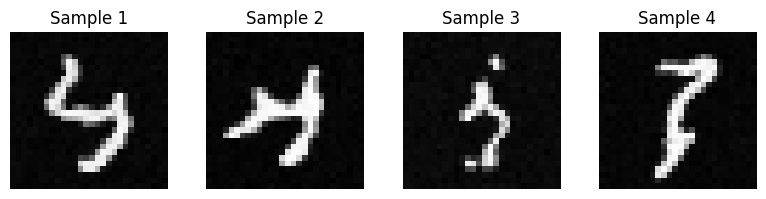

In [21]:
n_digits = 4
plt.figure(figsize=(n_digits * 2, 2))

for i in range(n_digits):
    plt.subplot(1, n_digits, i + 1)
    plt.imshow(samples[i, 0].cpu(), cmap='gray')
    plt.axis('off')
    plt.title(f"Sample {i+1}")

plt.tight_layout()
plt.show()

In [22]:
@parallel_on_all_devices
def multi_device_sample(per_device_samples):
    device = per_device_samples.device
    per_device_sample_shape = (per_device_samples.squeeze().item(), 1, 28, 28)

    per_gpu_model = NNHandler.load("notebooks/models/MNIST_score_models.pth", device=device)
    per_gpu_model._model = per_gpu_model.module # bypass NNHandler auto parallelization of the model

    # only print on device 0
    if torch.cuda.current_device() == 0:
        print(per_device_sample_shape)
    return per_gpu_model.sample(per_device_sample_shape, steps=100, bar=False)

samples_mGPU = multi_device_sample(torch.tensor([512, 512]))

INFO (Rank 0): Loading checkpoint 'MNIST_score_models.pth' to map_location='cuda:0' (Resolved: cuda:0)
INFO (Rank 0): Loading checkpoint 'MNIST_score_models.pth' to map_location='cuda:1' (Resolved: cuda:1)
WARN: No DDP environment variables found. Running non-DDP.
WARN: No DDP environment variables found. Running non-DDP.
(512, 1, 28, 28)


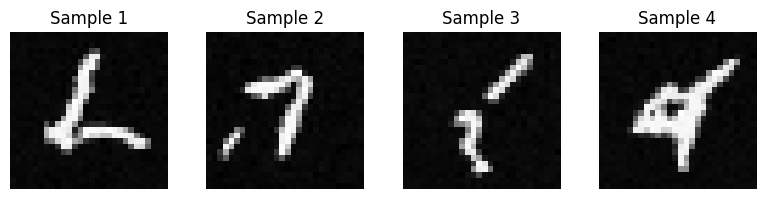

In [23]:
n_digits = 4
plt.figure(figsize=(n_digits * 2, 2))

for i in range(n_digits):
    plt.subplot(1, n_digits, i + 1)
    plt.imshow(samples_mGPU[i, 0].cpu(), cmap='gray')
    plt.axis('off')
    plt.title(f"Sample {i+1}")

plt.tight_layout()
plt.show()

In [24]:
%timeit -n 2 -r 2 multi_device_sample(torch.tensor([512, 512]))

INFO (Rank 0): Loading checkpoint 'MNIST_score_models.pth' to map_location='cuda:0' (Resolved: cuda:0)
INFO (Rank 0): Loading checkpoint 'MNIST_score_models.pth' to map_location='cuda:1' (Resolved: cuda:1)
WARN: No DDP environment variables found. Running non-DDP.
WARN: No DDP environment variables found. Running non-DDP.
(512, 1, 28, 28)
INFO (Rank 0): Loading checkpoint 'MNIST_score_models.pth' to map_location='cuda:0' (Resolved: cuda:0)INFO (Rank 0): Loading checkpoint 'MNIST_score_models.pth' to map_location='cuda:1' (Resolved: cuda:1)

WARN: No DDP environment variables found. Running non-DDP.
WARN: No DDP environment variables found. Running non-DDP.
(512, 1, 28, 28)
INFO (Rank 0): Loading checkpoint 'MNIST_score_models.pth' to map_location='cuda:0' (Resolved: cuda:0)
INFO (Rank 0): Loading checkpoint 'MNIST_score_models.pth' to map_location='cuda:1' (Resolved: cuda:1)
WARN: No DDP environment variables found. Running non-DDP.
WARN: No DDP environment variables found. Running non